In [273]:
import numpy as np
import pandas as pd
import scipy.optimize as scop
import matplotlib.pyplot as plt

import os
import ctypes
import sys
from sklearn.metrics import mean_squared_error as MSE
from scipy.interpolate import interp1d

sys.path.append("../src/python_scripts/")
from functions import scale, rescale, calculate_full_trace, give_me_ina,loss
import pygad

In [274]:
dirname = '../src/model_ctypes/ina/'

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')['value']

In [275]:
S = legend_states.copy()
R = S.copy() * 0
C = legend_constants.copy()
A = legend_algebraic.copy()

In [276]:
filename_protocol = "../data/protocols/protocol_79.csv"
df_protocol = pd.read_csv(filename_protocol, index_col=0) 
df_protocol

,t,v
0,0.00000,-80.0
1,0.00005,-80.0
2,0.00010,-80.0
3,0.00015,-80.0
4,0.00020,-80.0
...,...,...
99995,4.99975,-80.0
99996,4.99980,-80.0
99997,4.99985,-80.0
99998,4.99990,-80.0


In [277]:
#%%timeit
diff = (df_protocol.v.shift() - df_protocol.v).fillna(0)
mask_dense = diff.rolling(window=50).sum() != 0

indices_dense = mask_dense.index.to_numpy()[mask_dense]
indices_sparse = mask_dense.index.to_numpy()[~mask_dense][::10]

indices_all = np.concatenate([indices_dense, indices_sparse])
indices_all = np.sort(indices_all)

In [278]:
df_protocol_sparse = df_protocol.iloc[indices_all].copy()

In [279]:
output_len = len(df_protocol)

output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

In [280]:
bounds = np.array([[ 1e-14 , 1.0000000000000001e-11 ],
    [ 1e-12 , 1e-10 ],
    [ 100.0 , 100000.0 ],
    [ 1.0 , 1000.0 ],
    [ 1.0 , 100.0 ],
    [ 0.1 , 100.0 ],
    [ 0.01 , 10.0 ],
    [ 10.0 , 10000.0 ],
    [ 1.0 , 100.0 ],
    [ 1.0 , 100.0 ],
    [ 0.01 , 10.0 ],
    [ 1000.0 , 100000.0 ],
    [ 0.1 , 100.0 ],
    [ 10.0 , 1000.0 ],
    [ 1e-05 , 0.01 ],
    [ 1000000.0 , 1000000000.0 ],
    [ 1000.0 , 100000000.0 ],
    [ 1000.0 , 10000000.0 ],
    [ 0.01 , 1000.0 ],
    [ 1e-05 , 0.001 ],
    [ 1.0 , 100.0 ],
    [ 1.0 , 100.0 ],
    [ 0.1 , 10.0 ],
    [ 0.1 , 10.0 ],
    [ 0.01 , 1.1 ],
    [ 0.01 , 1.1 ],
    [ 0.01 , 1.0 ],
    [ -25.0 , 25.0 ],
    #[ -50.0 , 50.0 ],
    #[ -100.0 , 100.0 ]
         ])


In [281]:
#KWARGS SPARSE
t0_sparse = np.arange(0, 0.05, 5e-3)
v0_sparse = np.full_like(t0_sparse, -80.0)
initial_state_sparse_len = len(t0_sparse)

t_sparse = df_protocol_sparse['t'].values
v_sparse = df_protocol_sparse['v'].values
output_len = len(t_sparse)
initial_state_S_sparse = pd.DataFrame(np.zeros((initial_state_sparse_len, len(S))), columns=legend_states.index)
initial_state_A_sparse = pd.DataFrame(np.zeros((initial_state_sparse_len, len(A))), columns=legend_algebraic.index)

output_S_sparse = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A_sparse = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

kwargs_sparse = dict(S = S,
              t0 = t0_sparse,
              v0 = v0_sparse,
              initial_state_S = initial_state_S_sparse,
              initial_state_A = initial_state_A_sparse,
              initial_state_len = initial_state_sparse_len,
              
              t = t_sparse,
              v = v_sparse,
              output_S = output_S_sparse,
              output_A = output_A_sparse,
              interpolate = True,
              bounds = bounds.T
             )


In [282]:
filename = 'ina.so'
filename_so = os.path.join(dirname, filename)
filename_abs = os.path.abspath(filename_so)
filename_abs

'/home/nik/Documents/comparison/INa_full_trace/src/model_ctypes/ina/ina.so'

In [283]:
##KWARGS WORKING
t0 = np.arange(0, 0.25, 5e-5)
v0 = np.full_like(t0, -80.0)
initial_state_len = len(t0)

t = df_protocol['t'].values
v = df_protocol['v'].values
output_len = len(t)
initial_state_S = pd.DataFrame(np.zeros((initial_state_len, len(S))), columns=legend_states.index)
initial_state_A = pd.DataFrame(np.zeros((initial_state_len, len(A))), columns=legend_algebraic.index)

output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

kwargs = dict(S = S,
              t0 = t0,
              v0 = v0,
              initial_state_S = initial_state_S,
              initial_state_A = initial_state_A,
              initial_state_len = initial_state_len,
              filename_abs = filename_abs, 
              t = df_protocol['t'].values,
              v = df_protocol['v'].values,
              output_S = output_S,
              output_A = output_A,
              bounds = bounds.T
             )


In [284]:
p0 = C.value.values[:-2]
0.5*0.6*0.4

0.12

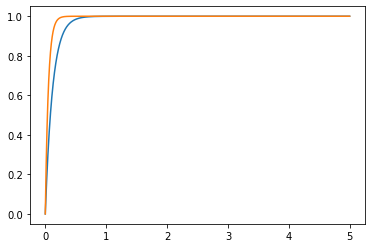

In [285]:
plt.plot(df_protocol.t.values, 1-np.exp(-df_protocol.t.values/(0.5*0.6*0.4)))
plt.plot(df_protocol.t.values, 1-np.exp(-df_protocol.t.values/0.05))

In [286]:
%%time
res = calculate_full_trace(scale(p0,*bounds.T), kwargs)

CPU times: user 705 ms, sys: 8.11 ms, total: 713 ms
Wall time: 717 ms


In [287]:
%matplotlib notebook

<IPython.core.display.Javascript object>


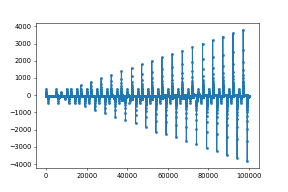

In [288]:
plt.figure()
plt.plot(output_S.I_out,'.-')
#plt.xlim(0, 160)
#plt.ylim(-100,400)

<IPython.core.display.Javascript object>


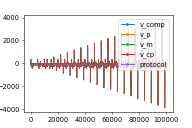

In [289]:
plt.figure()
for k in output_S.columns[:3]:
    plt.plot(output_S[k], '.-', label = k)
plt.plot(output_A.v_cp,'.-', label = 'v_cp')
plt.plot(df_protocol.v,'.-', label = 'protocol')
plt.legend()

In [290]:
k_list = np.array([79, 1079, 2079, 4079])
v_list = np.array([-80., -70., -80., -80.])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])

k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80.0,-70.0,-80.0, -10.0, -80.0])

In [82]:
dt = 5e-5
df_protocol = pd.DataFrame(np.vstack([np.array([0,*k_all]) * dt, v_all]).T, columns=['t', 'v'])

protocol = interp1d(df_protocol.t, df_protocol.v, kind='previous', bounds_error=False, fill_value=-80.)
import csv

In [83]:
protocol_to_csv = pd.DataFrame(np.stack([t, protocol(t)]).T, columns=['t', 'v'])
protocol_to_csv.to_csv('../../INa_full_trace/data/protocols/protocol_79.csv')

<IPython.core.display.Javascript object>


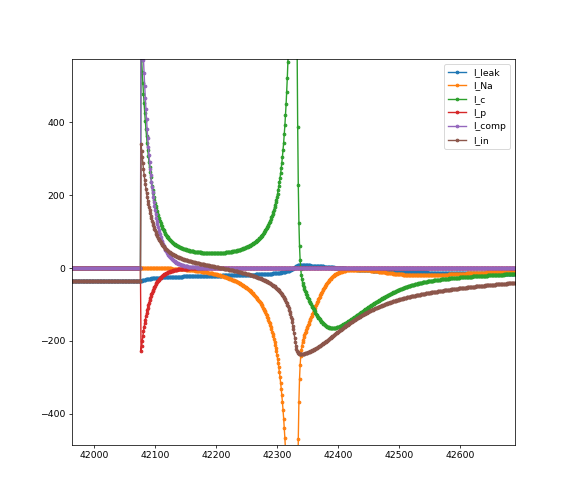

In [19]:
plt.figure()
for k in output_A.columns[6:]:
    plt.plot(output_A[k], '.-', label = k)
plt.legend()

In [88]:
def loss(y, *args):
    kwargs = args[-1]
    
    data = args[0]
    
    
    sample_weight = kwargs.get('sample_weight', None)

    I_out = calculate_full_trace(y, *args)
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [89]:
data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
exp_data = np.concatenate([data[k] for k in range(1,21)])

In [90]:
x0 =  C.value.values[:-2]

In [200]:
x0 = np.array([ 4.502963e-12,  2.473016e-11,  2.736956e+03,  7.135904e+01,
        2.061570e+01,  9.306083e+00,  4.604052e-01,  5.038082e+02,
        1.523480e+01,  2.196405e+01,  4.475461e-01,  2.061333e+04,
        4.115303e+00,  1.673159e+02,  7.794313e-04,  2.494677e+08,
        3.264214e+05,  4.392204e+05,  4.812443e-01,  1.000340e-04,
        2.435802e+01,  5.969117e+01,  5.666770e+00,  5.507771e+00,
        9.929933e-01,  0.620000e+00,  7.500000e-01, -2.500000e+00])
x = scale(x0,*bounds.T)

In [93]:
%%time

res = scop.minimize(loss,x, args = (exp_data, kwargs),method = 'Nelder-Mead',\
                    options={'adaptive':True, 'maxiter':10})
   

CPU times: user 26.3 s, sys: 0 ns, total: 26.3 s
Wall time: 26.3 s


In [150]:
%%time
loss(res.x,exp_data, kwargs)

CPU times: user 720 ms, sys: 0 ns, total: 720 ms
Wall time: 725 ms


19705.323738565166

<IPython.core.display.Javascript object>


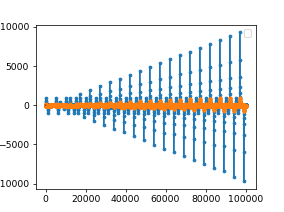

No handles with labels found to put in legend.


In [151]:
#%%time
%matplotlib notebook

#plt.plot(calculate_full_trace(x, kwargs),'.-')
plt.plot(calculate_full_trace(res.x, kwargs),'.-')
plt.plot(exp_data,'.-')
#for k in output_A.columns[6:]:
#    plt.plot(output_A[k],  '.-',label = k)
#for k in ['v_comp', 'v_p', 'v_m', 'I_out']:
#    plt.plot(output_S[k],  '.-',label = k)
plt.legend()

In [154]:
scale_bounds = [[0.,1.] for k in range(len(bounds))]
scale_bounds

[[0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0]]

In [155]:
bounds.T[0]

array([ 1.0e-14,  1.0e-12,  1.0e+02,  1.0e+00,  1.0e+00,  1.0e-01,
        1.0e-02,  1.0e+01,  1.0e+00,  1.0e+00,  1.0e-02,  1.0e+03,
        1.0e-01,  1.0e+01,  1.0e-05,  1.0e+06,  1.0e+03,  1.0e+03,
        1.0e-02,  1.0e-05,  1.0e+00,  1.0e+00,  1.0e-01,  1.0e-01,
        1.0e-02,  1.0e-02,  1.0e-02, -2.5e+01])

In [156]:
C.T.columns[22]

'k_m'

In [5]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=scale_bounds,
                                  args=(exp_data, kwargs),
                                  maxiter=5, 
                                  disp=False,
                                  popsize = 15,
                                  workers = 2,
                                  seed=42)

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


AttributeError: Can't pickle local object 'CDLL.__init__.<locals>._FuncPtr'

In [73]:
%%time
loss(res.x,exp_data, kwargs)

CPU times: user 146 ms, sys: 0 ns, total: 146 ms
Wall time: 165 ms


1331.361473015189

<IPython.core.display.Javascript object>


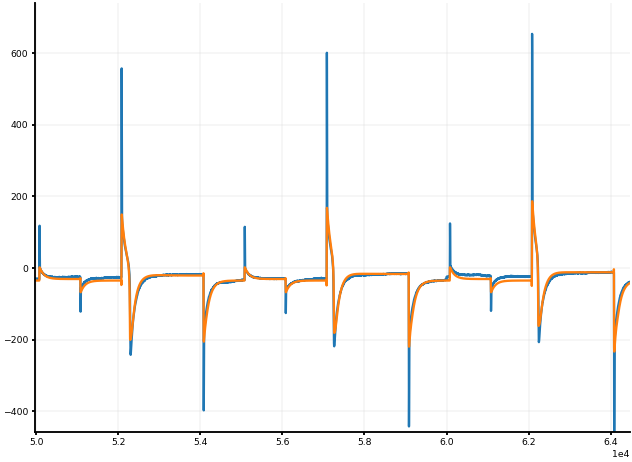

In [194]:
%matplotlib notebook
plt.plot(exp_data)
plt.plot(calculate_full_trace(res.x, kwargs))

In [192]:
x0

array([ 4.502963e-12,  2.473016e-11,  2.736956e+03,  7.135904e+01,
        2.061570e+01,  9.306083e+00,  4.604052e-01,  5.038082e+02,
        1.523480e+01,  2.196405e+01,  4.475461e-01,  2.061333e+04,
        4.115303e+00,  1.673159e+02,  7.794313e-04,  2.494677e+08,
        3.264214e+05,  4.392204e+05,  4.812443e-01,  1.000340e-04,
        2.435802e+01,  5.969117e+01,  5.666770e+00,  5.507771e+00,
        9.929933e-02,  1.020000e+00,  7.500000e-01, -2.500000e+00])

In [193]:
%%time
res = scop.dual_annealing(loss, bounds=scale_bounds, x0 = scale(x0,*bounds.T), args=(exp_data, kwargs), seed=18, maxiter=15)
loss(res.x, exp_data, kwargs)

/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/nik/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid

CPU times: user 11min 7s, sys: 537 ms, total: 11min 7s
Wall time: 11min 9s


348.16253956645727

array([ 4.502963e-12,  2.473016e-11,  2.736956e+03,  7.135904e+01,
        2.061570e+01,  9.306083e+00,  4.604052e-01,  5.038082e+02,
        1.523480e+01,  2.196405e+01,  4.475461e-01,  2.061333e+04,
        4.115303e+00,  1.673159e+02,  7.794313e-04,  2.494677e+08,
        3.264214e+05,  4.392204e+05,  4.812443e-01,  1.000340e-04,
        2.435802e+01,  5.969117e+01,  5.666770e+00,  5.507771e+00,
        9.929933e-01,  6.200000e-01,  7.500000e-01, -2.500000e+00])

In [109]:
from cmaes import CMA
import optuna


In [234]:
t0 = np.arange(0, 0.25, 5e-5)
v0 = np.full_like(t0, -80.0)
initial_state_len = len(t0)

t = df_protocol['t'].values
v = df_protocol['v'].values
output_len = len(t)
initial_state_S = pd.DataFrame(np.zeros((initial_state_len, len(S))), columns=legend_states.index)
initial_state_A = pd.DataFrame(np.zeros((initial_state_len, len(A))), columns=legend_algebraic.index)

output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

kwargs1 = dict(S = S,
              t0 = t0,
              v0 = v0,
              initial_state_S = initial_state_S,
              initial_state_A = initial_state_A,
              initial_state_len = initial_state_len,
              filename_abs = filename_abs, 
              t = df_protocol['t'].values,
              v = df_protocol['v'].values,
              output_S = output_S,
              output_A = output_A,
              bounds = bounds.T
             )

In [235]:
def loss1(y, idx):
    args = (exp_data, kwargs1)
    kwargs = args[-1]

    data = args[0]


    sample_weight = kwargs.get('sample_weight', None)

    I_out = calculate_full_trace(y, *args)
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf

    return 1/MSE(data, I_out, sample_weight=sample_weight)

In [212]:
scale_bounds

[[0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0]]

In [265]:
fitness_function = loss1

num_generations = 1000
num_parents_mating = 6
initial_population = x
sol_per_pop = 10
num_genes = len(x)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10
gene_space = scale_bounds

In [266]:
%%time
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space=gene_space,
                      )
ga_instance.run()

CPU times: user 5min 2s, sys: 836 ms, total: 5min 3s
Wall time: 5min 8s


In [194]:
%%time
if __name__ == "__main__":
    mean = np.zeros(28)
    sigma = 0.5
    optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)
    for generation in range(1):
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            value = loss(x,exp_data, kwargs)
            solutions.append((x, value))
            #print(f"#{generation} {value} (x={x})")
        optimizer.tell(solutions)


CPU times: user 8.87 s, sys: 801 µs, total: 8.87 s
Wall time: 8.87 s


/home/nik/.local/lib/python3.8/site-packages/cmaes/_cma.py:319: RuntimeWarning: overflow encountered in exp
  self._sigma *= np.exp(


In [316]:
result = pd.read_csv("../data/results/result_1.csv", index_col=0)


In [327]:
a = [0.5229974 , 0.25433779, 0.61332585 ,0.67833989, 0.52493476 ,0.40349649,
 0.78503966 ,0.73759595 ,0.50380974, 0.64720374, 0.69399094, 0.4966301,
 0.41924955 ,0.65354898 ,0.33269649, 0.9986073 , 0.02609741, 0.54361373,
 0.51302827 ,0.20847538 ,0.80373068, 0.45101004, 0.58051384 ,0.56345914,
 0.56346415 ,0.72196668 ,0.44092185, 0.94218296]

In [328]:
data = calculate_full_trace(x0, kwargs)
data_a = calculate_full_trace(a, kwargs)

<IPython.core.display.Javascript object>


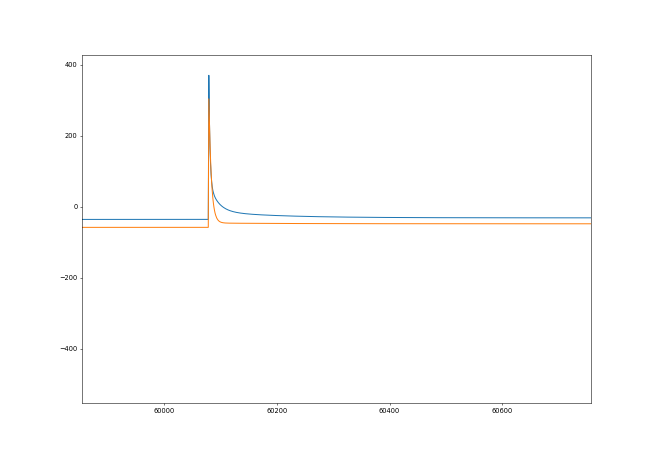

In [331]:
#x0 = scale(C.value.values[:-2],*bounds.T)
%matplotlib notebook
plt.plot(data)
plt.plot(data_a)

In [335]:
rescale(x0, *bounds.T)

array([ 1.5029630e-12,  2.4730160e-11,  2.7369560e+03,  7.1359040e+01,
        2.0615700e+01,  9.3060830e+00,  4.6040520e-01,  5.0380820e+02,
        1.5234800e+01,  2.1964050e+01,  4.4754610e-01,  2.0613330e+04,
        4.1153030e+00,  1.6731590e+02,  7.7943130e-04,  2.4946770e+08,
        1.2642140e+05,  4.3922040e+05,  4.8124430e-01,  1.0003400e-04,
        2.4358020e+01,  5.9691170e+01,  5.6667700e+00,  5.5077710e+00,
        5.9929933e-01,  8.0000000e-01,  7.5000000e-01, -2.5000000e+00])

In [336]:
rescale(a, *bounds.T)

array([5.23474403e-12, 2.61794412e-11, 6.13712524e+04, 6.78661550e+02,
       5.29685412e+01, 4.04092994e+01, 7.85254620e+00, 7.37858354e+03,
       5.08771643e+01, 6.50731703e+01, 6.94296949e+00, 5.01663799e+04,
       4.19830300e+01, 6.57013490e+02, 3.33363794e-03, 9.98608693e+08,
       2.61071490e+06, 5.43659369e+06, 5.13033140e+02, 2.16390626e-04,
       8.05693373e+01, 4.56499940e+01, 5.84708702e+00, 5.67824549e+00,
       6.24175924e-01, 7.96943681e-01, 4.46512632e-01, 2.21091480e+01])

In [293]:
%matplotlib inline